### Imports

In [14]:
# Exploration Notebook for ADAMMA Project
# Konstantinos Kalaitzidis

import pandas as pd
import numpy as np

# Inline plots
%matplotlib inline

import matplotlib.pyplot as plt
from pathlib import Path

### Load data

In [15]:
from pathlib import Path

# Load the raw data
RAW_PATH = Path("../data/raw/WISDM_clean.txt")
assert RAW_PATH.exists(), f"File not found: {RAW_PATH}"

### Quick sanity check

In [16]:
# Read the data into a DataFrame
df = pd.read_csv(RAW_PATH)
df.head()

,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
0,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
1,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
2,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
3,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;
4,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526;


In [17]:
# create header for the dataframe
df.columns = ['user', 'activity', 'timestamp', 'x', 'y', 'z']
df.head()

,user,activity,timestamp,x,y,z
0,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
1,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
2,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
3,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;
4,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526;


In [18]:
# Initial exploration
df.info()
df.describe(include="all")
df['activity'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098208 entries, 0 to 1098207
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098208 non-null  int64  
 1   activity   1098208 non-null  object 
 2   timestamp  1098208 non-null  int64  
 3   x          1098208 non-null  float64
 4   y          1098208 non-null  float64
 5   z          1098207 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 50.3+ MB


activity
Walking       424400
Jogging       342178
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: int64

In [19]:
# clean column names
df.columns = [c.strip().lower() for c in df.columns]

# drop missing values if any
df = df.dropna()
print(df.shape)
df.head()

(1098207, 6)


,user,activity,timestamp,x,y,z
0,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
1,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
2,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
3,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;
4,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526;


### Mapping activities to MET classes

In [20]:
# find unique activity names in the dataset
df['activity'].unique()

array(['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

In [21]:
### Mapping Activities to MET Classes
# MET (Metabolic Equivalent of Task) values for activities
# Sedentary: Sitting, Standing
# Light: Walking
# Moderate: Upstairs, Downstairs
# Vigorous: Jogging

MET_MAP = {
    'Sitting': 'Sedentary',
    'Standing': 'Sedentary',
    'Walking': 'Light',
    'Upstairs': 'Moderate',
    'Downstairs': 'Moderate',
    'Jogging': 'Vigorous'
}

df['met_class'] = df['activity'].map(MET_MAP)
df['met_class'].value_counts(dropna=False)
df.head()

,user,activity,timestamp,x,y,z,met_class
0,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;,Vigorous
1,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;,Vigorous
2,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;,Vigorous
3,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;,Vigorous
4,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526;,Vigorous


### Visualize and save traces

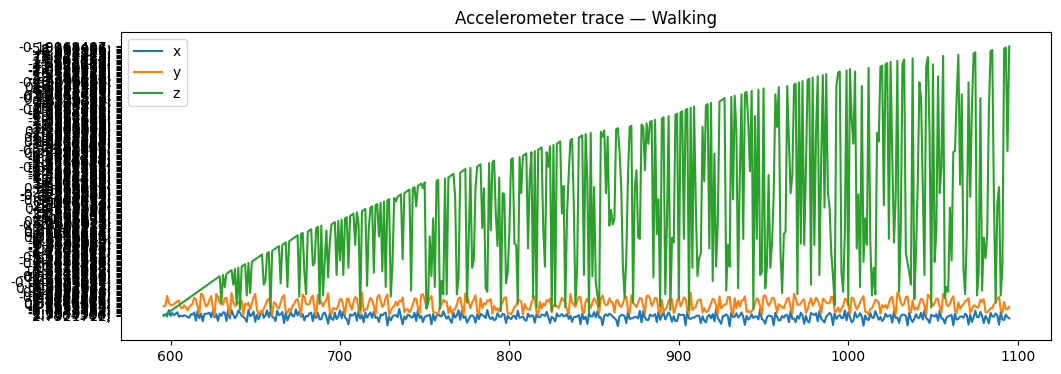

In [22]:
# Visualize some accelerometer data for a specific activity
plt.figure(figsize=(12,4))
sample = df[df['activity'] == 'Walking'].head(500)
for ax_name in ['x','y','z']:
    if ax_name in df.columns:
        plt.plot(sample[ax_name], label=ax_name)
plt.title("Accelerometer trace — Walking")
plt.legend()
plt.show()

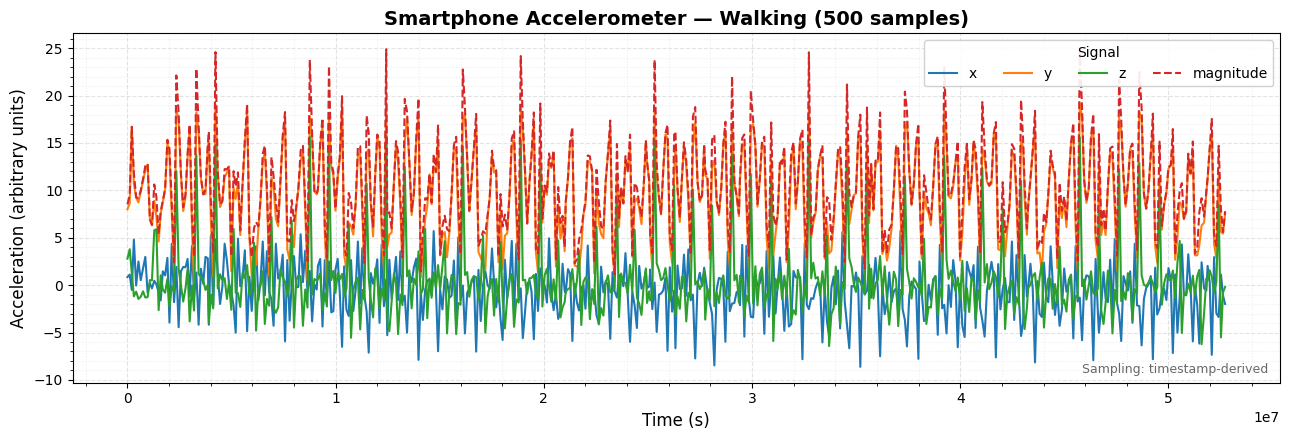

In [23]:
# ---- Config ----
ACTIVITY = "Walking" # Change to desired activity
N_SAMPLES = 500 # Number of samples to plot
ASSUMED_HZ = 20  # WISDM ≈ 20 Hz
SAVE_FIG = True
FIG_PATH = Path("../../docs/figures/wisdm_trace_walking.png")

# ---- Pick axis columns robustly ----
candidates_full = ["accel_x", "accel_y", "accel_z"]
candidates_short = ["x", "y", "z"]
if all(c in df.columns for c in candidates_full):
    AX_COLS = candidates_full
elif all(c in df.columns for c in candidates_short):
    AX_COLS = candidates_short
else:
    raise ValueError("Could not find accelerometer columns. Expected accel_x/accel_y/accel_z or x/y/z.")

# ---- Slice a sample window for a given activity ----
sample = df[df["activity"] == ACTIVITY].head(N_SAMPLES).copy()
if len(sample) < N_SAMPLES:
    print(f"Warning: only {len(sample)} samples available for {ACTIVITY}.")

# ---- Build a time axis (prefer timestamp if present; else assume fixed rate) ----
if "timestamp" in df.columns:
    # WISDM timestamps are typically in milliseconds; convert to seconds relative to start
    t = (sample["timestamp"] - sample["timestamp"].iloc[0]).to_numpy()
    # Heuristic: if values look large, treat as ms
    if t.max() > 1000:
        t = t / 1000.0
else:
    t = np.arange(len(sample)) / ASSUMED_HZ

# ---- Ensure all axis columns are numeric ----
for c in AX_COLS:
    if sample[c].dtype == 'O':
        sample[c] = pd.to_numeric(sample[c].str.replace(';', ''), errors='coerce')

# ---- Compute magnitude for extra context ----
mag = np.sqrt(np.sum([sample[c].to_numpy()**2 for c in AX_COLS], axis=0))

# ---- Plot ----
plt.figure(figsize=(13, 4.5))
for col in AX_COLS:
    plt.plot(t, sample[col], linewidth=1.5, label=col)

# Magnitude as dashed overlay
plt.plot(t, mag, linestyle="--", linewidth=1.5, label="magnitude")

# Titles & labels
plt.title(f"Smartphone Accelerometer — {ACTIVITY} ({len(sample)} samples)", fontsize=14, weight="bold")
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Acceleration (arbitrary units)", fontsize=12)


# Legend & grid
leg = plt.legend(title="Signal", ncols=4 if len(AX_COLS) == 3 else 3, frameon=True, framealpha=0.9)
plt.grid(True, which="major", linestyle="--", alpha=0.35)
plt.grid(True, which="minor", linestyle=":", alpha=0.2)
plt.minorticks_on()

# Info box
txt = f"Sampling: {'timestamp-derived' if 'timestamp' in df.columns else f'~{ASSUMED_HZ} Hz (assumed)'}"
plt.gca().text(0.99, 0.02, txt, transform=plt.gca().transAxes,
               ha="right", va="bottom", fontsize=9, color="dimgray")

plt.tight_layout()
if SAVE_FIG:
    FIG_PATH.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(FIG_PATH, dpi=150)
plt.show()
